In [1]:
import numpy as np
import gym
from gym import spaces
import random
from scipy.integrate import solve_ivp

class CSTRCoolingEnv(gym.Env):
    def __init__(self):
        super(CSTRCoolingEnv, self).__init__()

        # Parameters
        self.V = 100             # Reactor volume (L)
        self.q = 20             # Flowrate (L/min)
        self.Caf = 1.0           # Feed concentration (mol/L)
        self.Tf = 350            # Feed temperature (K)
        self.k0 = 15.2e10         # 1/min
        self.EoverR = 10000       # K
        self.mdelH = 5e4         # J/mol
        self.rho = 1000          # g/L
        self.Cp = 0.239          # J/g-K
        self.UA = 5e4            # J/min-K
        self.Tj_base = 300       # K
        self.Tj_delta = 30        # delta per action level
        self.dt = 1.0            # time per step (min)
        self.max_steps = 200
        self.possible_setpoints = [290,300,310,320,330,340,350,360,370]

        # Normalization ranges
        self.Ca_min = 0.0
        self.Ca_max = 1.2      # expected max around feed conc.

        self.T_min = 300.0
        self.T_max = 400.0      # may vary depending on dynamics


        # Action space: 3 discrete cooling settings
        self.action_space = spaces.Discrete(5)

        # Observation space: [Ca, T]
        low_obs = np.array([0.0, 300.0, 300.0], dtype=np.float32)
        high_obs = np.array([2.0, 500.0, 500.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low_obs, high=high_obs, dtype=np.float32)

        self.state = None
        self.steps = 0

    def step(self, action):
        Ca, T, sp = self.state

        sp = self.setpoints[self.steps]

        # Determine Tj based on action
        if action == 0:
            Tj = self.Tj_base + 2*self.Tj_delta
        elif action == 1:
            Tj = self.Tj_base + self.Tj_delta
        elif action == 2:
            Tj = self.Tj_base
        elif action == 3:
            Tj = self.Tj_base - self.Tj_delta
        elif action == 4:
            Tj = self.Tj_base - 2*self.Tj_delta

        # Integrate ODEs for 1 time step
        def cstr_odes(t, y):
            Ca, T = y
            rA = self.k0 * np.exp(-self.EoverR / T) * Ca
            dCadt = self.q / self.V * (self.Caf - Ca) - rA
            dTdt = (self.q / self.V * (self.Tf - T)
                    + (-self.mdelH) / (self.rho * self.Cp) * rA
                    + self.UA / (self.rho * self.Cp * self.V) * (Tj - T))
            return [dCadt, dTdt]

        sol = solve_ivp(cstr_odes, [0, self.dt], [Ca, T], method='RK45')
        Ca_next, T_next = sol.y[:, -1]

        self.state = np.array([Ca_next, T_next, sp], dtype=np.float32)

        # Reward: penalize deviation from setpoint
        reward = (-abs(T_next - sp))/100

        self.steps += 1
        done = self.steps >= self.max_steps

        obs = self.normalize_state(*self.state)
        return obs, reward, done, {}

    def generate_sectioned_list(self, C, num_sections=10, section_size=20):
        result = []
        for _ in range(num_sections):
            value = random.choice(C)
            section = [value] * section_size
            result.extend(section)
        return result

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps = 0
        Ca0 = 1.0
        T0 = 350.0 + self.np_random.uniform(-5.0, 5.0)  #5
        sp0 = 300.0
        C = self.possible_setpoints
        self.setpoints = self.generate_sectioned_list(C)
        self.state = np.array([Ca0, T0, sp0], dtype=np.float32)
        obs = self.normalize_state(*self.state)
        return obs, {}

    def render(self, mode='human'):
        Ca, T = self.state
        print(f"Step: {self.steps}, Ca: {Ca:.3f}, T: {T:.2f}")

    def normalize_state(self, Ca, T, sp):
        Ca_norm = (Ca - self.Ca_min) / (self.Ca_max - self.Ca_min)
        T_norm = (T - self.T_min) / (self.T_max - self.T_min)
        sp_norm = (sp - self.T_min) / (self.T_max - self.T_min)
        return np.array([Ca_norm, T_norm, sp_norm], dtype=np.float32)

    def close(self):
        pass


In [ ]:
import numpy as np
import torch
import tqdm
import gymnasium as gym
import matplotlib.pyplot as plt
import collections
import random
import csv
import warnings
warnings.filterwarnings("ignore")

# Deep Q Learning
# Daniel Rangel-Martinez

# Hyperparameters
hidden_size =           100
learning_rate =         5e-5
gamma =                 0.99
update_target_freq =    3
minibatch_size =        64
buff_size =             20_000
train_after =           50
episodes =              2000
train_epochs =          5
test_eps =              7
start_epsilon =         1.0
end_epsilon =           0.01

# Torch helper class
class TorchHelper:
    def __init__(self):
        if torch.cuda.is_available():
            self.device = torch.device("cpu")
            print("Working on CPU")
        else:
            self.device = torch.device("cpu")
            print("Working on CPU")

    def f(self, x):
        return torch.tensor(x, dtype=torch.float32).to(self.device)

    def i(self, x):
        return torch.tensor(x, dtype=torch.int32).to(self.device)

    def l(self, x):
        return torch.tensor(x, dtype=torch.long).to(self.device)

t = TorchHelper()
device = t.device

# Replay buffer
class ReplayBuffer:
    def __init__(self, N):
        self.buf = collections.deque(maxlen=N)

    def add(self, s, a, r, s2, d):
        self.buf.append((s, a, r, s2, d))

    def sample(self, n):
        minibatch = random.sample(self.buf, n)
        S, A, R, S2, D = zip(*minibatch)
        return t.f(S), t.l(A), t.f(R), t.f(S2), t.i(D)

# Create all the modules needed
def create_modules():
    # Environment
    env_1 = CSTRCoolingEnv()
    env_2 = CSTRCoolingEnv()

    # Replay Buffer
    buffer = ReplayBuffer(buff_size)

    # Q-Network
    Q = torch.nn.Sequential(
        torch.nn.Linear(obs_size, hidden_size),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.Linear(hidden_size, act_size)
    ).to(device)

    # Target Q-Network
    Q_t = torch.nn.Sequential(
        torch.nn.Linear(obs_size, hidden_size),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.Linear(hidden_size, act_size)
    ).to(device)

    # Optimizer
    optimizer = torch.optim.Adam(Q.parameters(), lr = learning_rate)

    return env_1, env_2, buffer, Q, Q_t, optimizer

# Target network update
def update_target(target, central):
    for t_params, c_params in zip(target.parameters(), central.parameters()):
        t_params.data.copy_(c_params)

# Epsilon-Greedy Decision Making Process
def policy(state, Q, epsilon):
    state = t.f(state).view(-1, obs_size)
    if np.random.rand() < epsilon:
        act = np.random.randint(act_size)
        return act
    else:
        act = torch.argmax(Q(state)).item()
        return act

# Training update
def update_Qnetworks(episode, buffer, Q, Qt, optimizer):
    s,a,r,s_,done = buffer.sample(minibatch_size)
    # Prediction with model
    q_values = Q(s).gather(1, a.view(-1,1)).squeeze()
    # Sampling and calculation of Q
    qt_values = Qt(s_).max(dim=1).values
    targets = r + gamma * qt_values * (1-done)
    # Calculate the error
    loss = torch.nn.MSELoss()(targets.detach(),q_values)

    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step

    # Update the target Q-Network
    if episode % update_target_freq == 0:
        update_target(Qt, Q)

    return loss.item()

def play_episode(env, Q, epsilon, buf=None, max_steps=100):
    obs, _ = env.reset(seed=123)
    done = False
    states, actions, rewards = [], [], []

    for _ in range(max_steps):
        act = policy(obs, Q, epsilon)
        next_obs, reward, done, _ = env.step(act)

        if buf is not None:
            buf.add(obs, act, reward, next_obs, done)

        states.append(obs)
        actions.append(act)
        rewards.append(reward)

        obs = next_obs
        if done:
            break

    return states, actions, rewards

# Training Function
def train():
    global obs_size, act_size

    env = CSTRCoolingEnv()
    test_env = CSTRCoolingEnv()

    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    Q = torch.nn.Sequential(
        torch.nn.Linear(obs_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, act_size)
    ).to(device)

    Qt = torch.nn.Sequential(
        torch.nn.Linear(obs_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, act_size)
    ).to(device)

    optimizer = torch.optim.Adam(Q.parameters(),lr=learning_rate)
    buffer = ReplayBuffer(buff_size)
    epsilon = start_epsilon

    rewards, rewards_samples = [], []

    print("Training")
    bar = tqdm.trange(episodes)
    for episode in bar:
        s,a,r = play_episode(env, Q, epsilon, buf=buffer)

        if episode >= train_after:
            for i in range(train_epochs):
                update_Qnetworks(episode, buffer, Q, Qt, optimizer)

        rews = []
        for j in range(test_eps):
            _, _, r = play_episode(test_env, Q, epsilon)
            rews += [sum(r)]
        rewards += [sum(rews)/test_eps]

        if episode % (episodes) == 0:
            torch.save(Q.state_dict(), f"dqn_actor_3{episode}.pth")

        # Progress bar
        rewards_samples += [sum(rewards[-25:])/len(rewards[-25:])]
        bar.set_description("Reward(%g), Epsilon(%g)" % (rewards_samples[-1], epsilon))

        f = open('Rewards', 'a')
        writer = csv.writer(f, lineterminator = '\n')
        writer.writerow([rewards_samples[-1]])
        f.close()

        epsilon = start_epsilon * (end_epsilon/start_epsilon)**(episode/episodes)

    # Close once finished
    bar.close()
    env.close()
    test_env.close()

    return rewards_samples

# Plot the mean learning curve from multiple training runs
def plot_arrays(vars, color, label):
    mean = np.mean(vars, axis=0)
    std = np.std(vars, axis=0)
    plt.plot(range(len(mean)), mean, color=color, label=label)
    plt.fill_between(range(len(mean)), np.maximum(mean-std, -1000), np.minimum(mean+std,1000), color=color, alpha=0.3)

# Main
if __name__ == "__main__":

    open("rewards", "w").close()

    training_runs = []
    for i in range(1):
        training_runs.append(train())

    plt.figure(figsize=(12, 6))
    plot_arrays(training_runs, 'b', 'DQN on MountainCar')
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.title("DQN Learning Curve")
    plt.grid(True)
    plt.legend()
    plt.show()





Working on CUDA
Training


Reward(-41.8146), Epsilon(0.885116):   3%|▎         | 55/2000 [00:29<18:38,  1.74it/s]

In [8]:
import numpy as np
import csv
import torch

# Torch helper class
class TorchHelper:
    def __init__(self):
        if torch.cuda.is_available():
            self.device = torch.device("cpu")
            print("Working on CUDA")
        else:
            self.device = torch.device("cpu")
            print("Working on CUDA")

    def f(self, x):
        return torch.tensor(x, dtype=torch.float32).to(self.device)

    def i(self, x):
        return torch.tensor(x, dtype=torch.int32).to(self.device)

    def l(self, x):
        return torch.tensor(x, dtype=torch.long).to(self.device)

t = TorchHelper()
DEVICE = t.device

def tester(policy):
    Q = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN),
        torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN),
        torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN),
        torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)

    Q.load_state_dict(policy)

    state, _ = env.reset()
    reward = 0.0
    done = False
    action = 1
    while not done:
        f = open('episode_test', 'a')
        writer = csv.writer(f, lineterminator = '\n')
        writer.writerow([state, reward, done, action])
        f.close()

        state_ = torch.from_numpy(state)
        action = Q(state_)
        action = torch.argmax(action).item()
        next_state, reward, done, _ = env.step(action)
        state = next_state

if __name__ == "__main__":
    open('episode_test', 'w').close()
    HIDDEN = 100
    policy = torch.load("dqn_actor_31999.pth")
    env = CSTRCoolingEnv()
    OBS_N = env.observation_space.shape[0]
    ACT_N = env.action_space.n
    tester(policy)

Working on CUDA


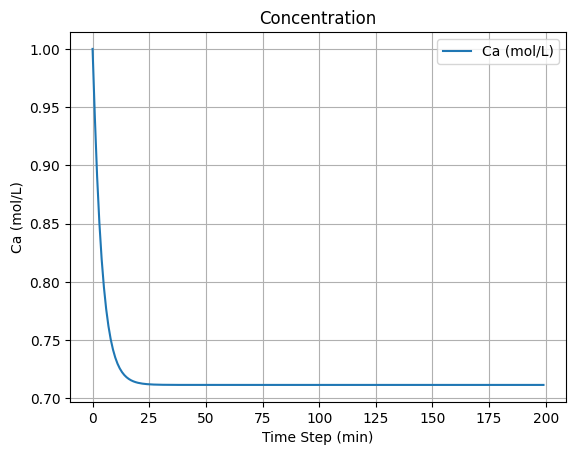

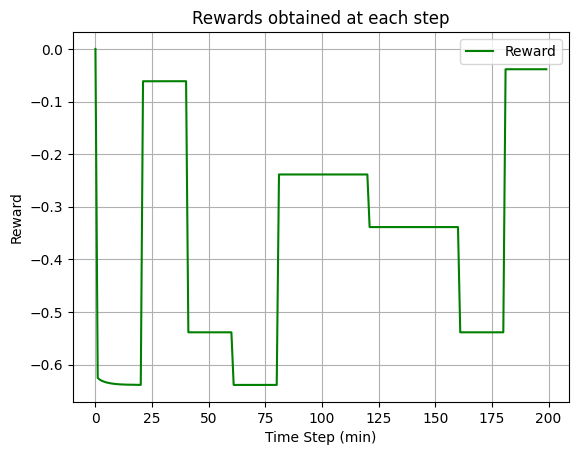

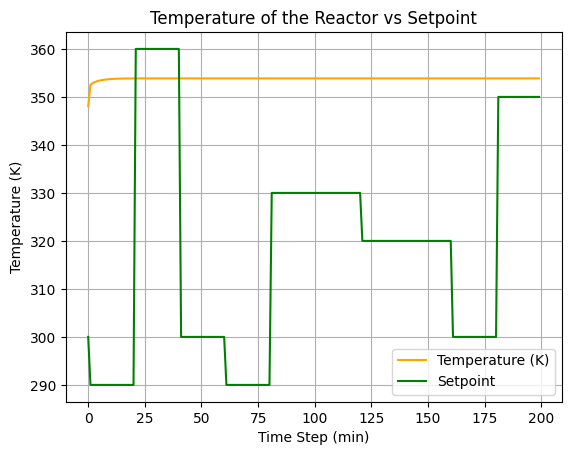

In [9]:
import matplotlib.pyplot as plt

Ca_min, Ca_max = 0.0, 1.2
T_min, T_max = 300.0, 400.0

def unnormalize_state(ca_norm, t_norm, sp_norm):
    ca = ca_norm * (Ca_max - Ca_min) + Ca_min
    t = t_norm * (T_max - T_min) + T_min
    sp = sp_norm * (T_max - T_min) + T_min
    #Tj = tj_norm * (T_max - T_min) + T_min
    return ca, t, sp


states_Ca = []
states_T = []
rewards = []
actions = []
setpoints = []

with open("episode_test", "r") as file:
    for line in file:
        parts = line.strip().split("],")
        state_str = parts[0].replace("[", "")
        rest = parts[1].split(",", 3)

        reward = float(rest[0])
        action = int(rest[2])


        ca_norm, t_norm, sp = map(float, state_str.strip().split())
        ca, t, sp = unnormalize_state(ca_norm, t_norm, sp)

        states_Ca.append(ca)
        states_T.append(t)
        rewards.append(reward)
        actions.append(action)
        setpoints.append(sp)

#plt.figure(figsize=(15, 12))

# 1. Ca
plt.plot(states_Ca, label="Ca (mol/L)")
plt.title("Concentration")
plt.ylabel("Ca (mol/L)")
plt.xlabel("Time Step (min)")
plt.grid(True)
plt.legend()
plt.show()

# 3. Reward
plt.plot(rewards, label="Reward", color='green')
plt.title("Rewards obtained at each step")
plt.ylabel("Reward")
plt.xlabel("Time Step (min)")
plt.grid(True)
plt.legend()
plt.show()
# 4. Tj (Jacket Temp)

# 5. Tj (Jacket Temp)
plt.plot(states_T, label="Temperature (K)", color='orange')
plt.plot(setpoints, label="Setpoint", color='green')
plt.title("Temperature of the Reactor vs Setpoint")
plt.ylabel("Temperature (K)")
plt.xlabel("Time Step (min)")
plt.grid(True)
plt.legend()
plt.show()

# New Section